# Setting Up The Environment

In [1]:
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [2]:
!pip install kaggle

import os
os.environ['KAGGLE_USERNAME'] = "pideeell"
os.environ['KAGGLE_KEY'] = "a917e24c299339667d5610765517f26b"

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from imblearn.under_sampling import RandomUnderSampler
import json
import random

# Datasets and Genre List

In [4]:
!kaggle datasets download -d maharshipandya/-spotify-tracks-dataset
!unzip -o '/-spotify-tracks-dataset.zip' -d '/dataset/'
!rm '/-spotify-tracks-dataset.zip'

Dataset URL: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset
License(s): ODbL-1.0
 61% 5.00M/8.17M [00:00<00:00, 30.8MB/s]
100% 8.17M/8.17M [00:00<00:00, 40.6MB/s]
Archive:  /content/-spotify-tracks-dataset.zip
  inflating: /content/dataset/dataset.csv  


In [5]:
!kaggle datasets download -d arashnic/fitbit
!unzip -o '/fitbit.zip' -d '/dataset/'
!rm '/fitbit.zip'

Dataset URL: https://www.kaggle.com/datasets/arashnic/fitbit
License(s): CC0-1.0
 62% 27.0M/43.3M [00:00<00:00, 66.7MB/s]
100% 43.3M/43.3M [00:00<00:00, 75.4MB/s]
Archive:  /content/fitbit.zip
  inflating: /content/dataset/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/dailyActivity_merged.csv  
  inflating: /content/dataset/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/heartrate_seconds_merged.csv  
  inflating: /content/dataset/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlyCalories_merged.csv  
  inflating: /content/dataset/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlyIntensities_merged.csv  
  inflating: /content/dataset/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlySteps_merged.csv  
  inflating: /content/dataset/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteCaloriesNarrow_merged.csv  
  inflating: /content/dataset/mturkfitbit_export_3.12.16-4.11

In [3]:
# Read CSV
df_Intensities = pd.read_csv('dataset/arashnic-fitbit/mturkfitbit_export_3.12.16-4.11.16/minuteIntensitiesNarrow_merged.csv')
df_HR = pd.read_csv('dataset/arashnic-fitbit/mturkfitbit_export_3.12.16-4.11.16/heartrate_seconds_merged.csv')
df_Calories = pd.read_csv('dataset/arashnic-fitbit/mturkfitbit_export_3.12.16-4.11.16/minuteCaloriesNarrow_merged.csv')
df_METs = pd.read_csv('dataset/arashnic-fitbit/mturkfitbit_export_3.12.16-4.11.16/minuteMETsNarrow_merged.csv')

df_Intensities1 = pd.read_csv('dataset/arashnic-fitbit/mturkfitbit_export_4.12.16-5.12.16/minuteIntensitiesNarrow_merged.csv')
df_HR1 = pd.read_csv('dataset/arashnic-fitbit/mturkfitbit_export_4.12.16-5.12.16/heartrate_seconds_merged.csv')
df_Calories1 = pd.read_csv('dataset/arashnic-fitbit/mturkfitbit_export_4.12.16-5.12.16/minuteCaloriesNarrow_merged.csv')
df_METs1 = pd.read_csv('dataset/arashnic-fitbit/mturkfitbit_export_4.12.16-5.12.16/minuteMETsNarrow_merged.csv')

# Concatenate df
df_HR = pd.concat([df_HR, df_HR1], ignore_index=True)
df_Intensities = pd.concat([df_Intensities, df_Intensities1], ignore_index=True)
df_Calories = pd.concat([df_Calories, df_Calories1], ignore_index=True)
df_METs = pd.concat([df_METs, df_METs1], ignore_index=True)

# Rename columns
df_HR.rename(columns={'Time': 'ActivityMinute'}, inplace=True)
df_HR.rename(columns={'Value': 'HR'}, inplace=True)

# Merge df
df_fitness = df_Intensities.merge(df_HR, on=['Id', 'ActivityMinute'], how='inner') \
                       .merge(df_Calories, on=['Id', 'ActivityMinute'], how='inner') \
                       .merge(df_METs, on=['Id', 'ActivityMinute'], how='inner')

In [5]:
# Create a dictionary to map genres to their respective heart rate intensities
genre_to_intensity = {
    'acoustic': {0, 1},
    'afrobeat': {1, 2},
    'alt-rock': {1, 2, 3},
    'alternative': {1, 2},
    'ambient': {0, 1},
    'anime': {0, 1, 2},
    'bluegrass': {0, 1},
    'blues': {0, 1},
    'brazil': {1, 2},
    'breakbeat': {2, 3},
    'british': {1, 2},
    'chill': {0, 1},
    'club': {2, 3},
    'country': {0, 1},
    'dance': {1, 2, 3},
    'dancehall': {2, 3},
    'deep-house': {1, 2},
    'disco': {1, 2},
    'drum-and-bass': {2, 3},
    'dubstep': {2, 3},
    'edm': {2, 3},
    'electro': {2, 3},
    'electronic': {1, 2},
    'folk': {0, 1},
    'funk': {1, 2},
    'garage': {2, 3},
    'grunge': {1, 2, 3},
    'hard-rock': {2, 3},
    'hip-hop': {1, 2, 3},
    'house': {2, 3},
    'indie': {1, 2},
    'j-dance': {2, 3},
    'j-pop': {1, 2},
    'j-rock': {2, 3},
    'jazz': {0, 1},
    'k-pop': {1, 2},
    'latin': {1, 2, 3},
    'metal': {2, 3},
    'metalcore': {3},
    'minimal-techno': {1, 2},
    'party': {2, 3},
    'pop': {1, 2, 3},
    'power-pop': {2, 3},
    'progressive-house': {2, 3},
    'psych-rock': {1, 2},
    'punk-rock': {2, 3},
    'punk': {2, 3},
    'r-n-b': {1, 2},
    'reggae': {1, 2},
    'reggaeton': {2, 3},
    'rock-n-roll': {2, 3},
    'rock': {2, 3},
    'rockabilly': {1, 2},
    'salsa': {1, 2, 3},
    'ska': {2, 3},
    'soul': {0, 1, 2},
    'spanish': {1, 2},
    'synth-pop': {1, 2},
    'techno': {2, 3},
    'trance': {2, 3},
    'trip-hop': {1, 2},
    'world-music': {1, 2}
}


# Convert sets to lists in the dictionary
for key, value in genre_to_intensity.items():
    if isinstance(value, set):
        genre_to_intensity[key] = list(value)


!mkdir model

# Save the dictionary to a JSON file
with open("model/genre_to_intensity.json", "w") as outfile:
    json.dump(genre_to_intensity, outfile)

A subdirectory or file model already exists.


# Data Preprocessing and User Initialization

In [6]:
# Song Dataset
def load_and_clean_music_data(filepath):
    """
    Loads music data from a CSV file and performs initial cleaning.

    Parameters:
    filepath (str): Path to the CSV file containing music data.

    Returns:
    pd.DataFrame: Cleaned DataFrame with selected columns and duplicates removed.
    """

    df = pd.read_csv(filepath)
    df = df[['track_id', 'track_name', 'artists', 'track_genre', 'popularity', 'energy', 'tempo', 'valence', 'danceability', 'loudness']]
    df.drop_duplicates(subset=['track_id'], inplace=True)
    return df


def load_genre_to_intensity(filepath):
    """
    Loads a mapping from genres to intensity levels from a JSON file.

    Parameters:
    filepath (str): Path to the JSON file containing genre-to-intensity mapping.

    Returns:
    dict: Dictionary mapping genres to intensity levels.
    """

    with open(filepath, 'r') as file:
        return json.load(file)


def assign_intensity(row, genre_to_intensity):
    """
    Assigns intensity levels to a song based on its genre, tempo, and energy.

    Parameters:
    row (pd.Series): A row from the DataFrame containing song details.
    genre_to_intensity (dict): Dictionary mapping genres to intensity levels.

    Returns:
    set: Set of matched intensity levels or None if no matches are found.
    """

    genre = row['track_genre'].lower()
    tempo = row['tempo']
    energy = row['energy']

    intensity_set = genre_to_intensity.get(genre)
    if intensity_set is None:
        return None

    matched_intensities = set()
    if 0 in intensity_set and 50 <= tempo <= 90 and energy >= 0.6:
        matched_intensities.add(0)
    if 1 in intensity_set and 80 <= tempo <= 120 and energy >= 0.7:
        matched_intensities.add(1)
    if 2 in intensity_set and 110 <= tempo <= 140 and energy >= 0.75:
        matched_intensities.add(2)
    if 3 in intensity_set and tempo > 120 and energy >= 0.85:
        matched_intensities.add(3)

    return matched_intensities if matched_intensities else None

In [7]:
# Fitness Dataset
def preprocess_fitness_data(df_all):
    """
    Preprocesses fitness data by performing under-sampling to balance the dataset.

    Parameters:
    df_all (pd.DataFrame): DataFrame containing the complete dataset with features and target.

    Returns:
    pd.DataFrame: DataFrame with balanced classes after under-sampling.
    """

    X = df_all.drop(columns=['Intensity'])
    y = df_all['Intensity']
    under_sampling = RandomUnderSampler(random_state=42)
    X_us, y_us = under_sampling.fit_resample(X, y)
    return pd.concat([X_us, y_us], axis=1)


def feature_scaling(X_train, X_test):
    """
    Scales features using StandardScaler.

    Parameters:
    X_train (pd.DataFrame or np.array): Training data features.
    X_test (pd.DataFrame or np.array): Test data features.

    Returns:
    StandardScaler: The fitted scaler object.
    np.array: Scaled training data features.
    np.array: Scaled test data features.
    """

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return scaler, X_train, X_test

# Model Training

## Functions

In [9]:
# Model Training

def hyperparameter_tuning(X_train, y_train):
    """
    Performs hyperparameter tuning for a RandomForestClassifier using GridSearchCV.

    Parameters:
    X_train (pd.DataFrame or np.array): Training data features.
    y_train (pd.Series or np.array): Training data labels.

    Returns:
    dict: Best hyperparameters found during the grid search.
    """

    param_distributions = {
        'n_estimators': [2, 3, 5, 8, 10],
        'max_depth': [2, 3, 5, 7, 8, 10],
        'min_samples_split': [2, 3, 4, 5],
        'min_samples_leaf': [1, 2, 4],
    }

    model = RandomForestClassifier(random_state=42)
    search = GridSearchCV(estimator=model, param_grid=param_distributions, n_jobs=-1, verbose=3)
    search.fit(X_train, y_train)

    return search.best_params_


def train_model(X_train, y_train, best_params):
    """
    Trains a RandomForestClassifier with the best hyperparameters.

    Parameters:
    X_train (pd.DataFrame or np.array): Training data features.
    y_train (pd.Series or np.array): Training data labels.
    best_params (dict): Dictionary of best hyperparameters for the model.

    Returns:
    RandomForestClassifier: The trained RandomForestClassifier model.
    """

    final_model = RandomForestClassifier(**best_params)
    final_model.fit(X_train, y_train)

    return final_model


def evaluate_model(model, X_test, y_test):
    """
    Evaluates a trained model on the test data.

    Parameters:
    model (RandomForestClassifier): The trained model to be evaluated.
    X_test (pd.DataFrame or np.array): Test data features.
    y_test (pd.Series or np.array): Test data labels.

    Returns:
    None
    """

    y_pred = model.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Classification Report: \n", classification_report(y_test, y_pred))

In [10]:
def cluster_songs(df_assign, num_clusters=100):
    """
    Clusters songs based on their features and genres.

    - Selects relevant features ('popularity', 'energy', 'tempo', 'valence', 'danceability', 'loudness') for clustering.
    - One-hot encodes the 'track_genre' column.
    - Combines the encoded genres with other song features.
    - Scales the combined features.
    - Performs KMeans clustering on the scaled features.
    - Assigns cluster labels to the original DataFrame.

    Parameters:
    df_assign (pd.DataFrame): DataFrame containing song data with columns ['track_id', 'track_name', 'artists', 'track_genre', 'popularity', 'energy', 'tempo', 'valence', 'danceability', 'loudness'].
    num_clusters (int): Number of clusters to form.

    Returns:
    pd.DataFrame: DataFrame with an additional 'cluster' column indicating the assigned cluster for each song.
    KMeans: Fitted KMeans model.
    """

    df_assign_used = df_assign[['popularity', 'energy', 'tempo', 'valence', 'danceability', 'loudness']]

    # One-hot encode 'track_genre'
    encoder = OneHotEncoder()
    encoded_genres = encoder.fit_transform(df_assign[['track_genre']])

    # Convert to DataFrame
    encoded_genres_df = pd.DataFrame(encoded_genres.toarray(), columns=encoder.get_feature_names_out(['track_genre']))

    # Combine with other song features
    song_features = pd.concat([df_assign_used.reset_index(drop=True), encoded_genres_df.reset_index(drop=True)], axis=1)

    # Scale the data
    scaler = StandardScaler()
    scaled_song_features = scaler.fit_transform(song_features)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    df_assign['cluster'] = kmeans.fit_predict(scaled_song_features)
    return df_assign, kmeans


## Hyperparameter Tuning

In [13]:
# Hyperparameter Tuning

def hyperparameter_train():
    """
    hyperparameter_train function for hyperparameter tuning.

    - Loads and cleans the music dataset.
    - Assigns intensity to songs based on genre, tempo, and energy.
    - Preprocesses fitness data.
    - Splits the data into training and test sets.
    - Scales the features.
    - Performs hyperparameter tuning for a RandomForestClassifier.
    - Prints the best hyperparameters found.

    Returns:
    None
    """

    # Load and clean datasets
    music_data_path = 'dataset/maharshipandya-spotify-tracks-dataset/dataset.csv'

    df_music = load_and_clean_music_data(music_data_path)
    genre_to_intensity = load_genre_to_intensity('model/genre_to_intensity.json')
    df_music['intensity'] = df_music.apply(lambda row: assign_intensity(row, genre_to_intensity), axis=1)
    df_music.dropna(subset=['intensity'], inplace=True)
    df_music['intensity'] = df_music['intensity'].apply(lambda x: set(x))

    df_all = preprocess_fitness_data(df_fitness)

    X = df_all[['HR']]
    y = df_all['Intensity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler, X_train_scaled, X_test_scaled = feature_scaling(X_train, X_test)

    model = hyperparameter_tuning(X_train_scaled, y_train)
    print(model)

if __name__ == "__main__":
    hyperparameter_train()


Fitting 5 folds for each of 360 candidates, totalling 1800 fits
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}


## Training Execution

In [14]:
# Training Execution

def model_train():
    """
    model_train function for training execution.

    - Loads and cleans the music dataset.
    - Assigns intensity to songs based on genre, tempo, and energy.
    - Preprocesses fitness data.
    - Splits the data into training and test sets.
    - Scales the features.
    - Trains a RandomForestClassifier with the best hyperparameters.
    - Evaluates the trained model on the test set.
    - Saves the trained model and scaler.
    - Clusters the songs using KMeans.
    - Saves the clustered songs and the KMeans model.

    Returns:
    None
    """

    # Load and clean datasets
    music_data_path = 'dataset/maharshipandya-spotify-tracks-dataset/dataset.csv'

    df_music = load_and_clean_music_data(music_data_path)
    genre_to_intensity = load_genre_to_intensity('model/genre_to_intensity.json')
    df_music['intensity'] = df_music.apply(lambda row: assign_intensity(row, genre_to_intensity), axis=1)
    df_music.dropna(subset=['intensity'], inplace=True)
    df_music['intensity'] = df_music['intensity'].apply(lambda x: set(x))

    df_all = preprocess_fitness_data(df_fitness)

    X = df_all[['HR']]
    y = df_all['Intensity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler, X_train_scaled, X_test_scaled = feature_scaling(X_train, X_test)

    best_params = {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
    model = train_model(X_train_scaled, y_train, best_params)
    evaluate_model(model, X_test_scaled, y_test)

    # Save model and scaler
    joblib.dump(model, 'model/final_model.pkl')
    joblib.dump(scaler, 'model/scaler.pkl')

    # Cluster songs
    df_music, kmeans = cluster_songs(df_music, num_clusters=113)
    df_music.to_csv('dataset/clustered_song.csv', index=True)
    joblib.dump(kmeans, 'model/kmeans.pkl')

if __name__ == "__main__":
    model_train()

Accuracy:  0.6127730294396961
Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.76      0.76      1049
           1       0.50      0.47      0.48      1102
           2       0.48      0.49      0.48      1015
           3       0.70      0.74      0.72      1046

    accuracy                           0.61      4212
   macro avg       0.61      0.61      0.61      4212
weighted avg       0.61      0.61      0.61      4212



C:\Users\doubl\PycharmProjects\Simulasi Ujian TensorFlow Developer Certificate\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Inference

In [1]:
import joblib
import pandas as pd
import json

In [2]:
class User:
    """
    Represents a user with methods to manage liked songs and preferences.

    Attributes:
    user_id (str): The unique identifier of the user.
    liked_songs (set): A set of track IDs representing songs the user likes.
    """
    def __init__(self, user_id):
        self.user_id = user_id
        self.liked_songs = set()

    def like_song(self, song_id):
        self.liked_songs.add(song_id)

    def get_liked_songs(self):
        return list(self.liked_songs)

    def save_preferences(self, filepath='/dataset/user_preferences.json'):
        with open(filepath, 'w') as file:
            json.dump({'user_id': self.user_id, 'liked_songs': list(self.liked_songs)}, file)

    def load_preferences(self, filepath='/dataset/user_preferences.json'):
        try:
            with open(filepath, 'r') as file:
                data = json.load(file)
                self.liked_songs = set(data.get('liked_songs', []))
        except FileNotFoundError:
            pass

In [3]:
# Recommendation System

def recommend_songs(predicted_intensity, df_assign, num_songs=5, liked_songs=[], song_clusters=None):
    """
    Recommends songs based on predicted intensity, with higher probability given to more
    popular songs and songs from clusters of liked songs.

    Parameters:
    predicted_intensity (int): Desired intensity level for the recommended songs.
    df_assign (pd.DataFrame): DataFrame containing song details (track_id, track_name, artists,
                              track_genre, intensity, energy, popularity, etc.).
    num_songs (int): Number of songs to recommend. Default is 5.
    liked_songs (list): List of track IDs representing songs the user likes.
    song_clusters (pd.DataFrame): DataFrame containing song clusters (track_id, cluster). Default is None.

    Returns:
    pd.DataFrame: DataFrame containing the recommended songs with selected details
                  (track_id, track_name, artists, track_genre, intensity, energy, popularity, cluster).
    """

    df_assign['intensity'] = df_assign['intensity'].apply(lambda x: {int(i) for i in x.replace('{', '').replace('}', '').split(',') if i.strip().isdigit()} if isinstance(x, str) else x)

    recommended_df = df_assign[df_assign['intensity'].apply(lambda x: predicted_intensity in x)].copy()
    if recommended_df.empty:
        if predicted_intensity == 0:
            recommended_df = df_assign[df_assign['intensity'].apply(lambda x: 1 in x)].copy()
        elif predicted_intensity == 3:
            recommended_df = df_assign[df_assign['intensity'].apply(lambda x: 2 in x)].copy()
        else:
            recommended_df = df_assign[df_assign['intensity'].apply(lambda x: (predicted_intensity - 1 in x) or (predicted_intensity + 1 in x))].copy()

    recommended_df['weight'] = recommended_df['popularity'].apply(lambda pop: 1 if pop > 60 else (0.2 if 45 < pop <= 60 else 0.08))

    if liked_songs:
        if song_clusters is not None:
            liked_song_clusters = song_clusters[song_clusters['track_id'].isin(liked_songs)]['cluster'].unique()
            recommended_df['weight'] += recommended_df['track_id'].apply(
                lambda x: 1 if x in song_clusters[song_clusters['cluster'].isin(liked_song_clusters)]['track_id'].values else 0
            )

        recommended_df['weight'] += recommended_df['track_id'].apply(lambda x: 0.5 if x in liked_songs else 0.2)

    print("Weights assigned:", recommended_df['weight'].value_counts())

    if len(recommended_df) < num_songs:
        num_songs = len(recommended_df)

    recommended_songs = recommended_df.sample(n=num_songs, weights='weight')

    return recommended_songs[['track_id', 'track_genre', 'intensity', 'energy', 'popularity', 'cluster']]

In [4]:
# Main Execution

def inference():
    """
    Inference execution function for the music recommendation system.

    - Loads the pre-trained scaler and model.
    - Reads the clustered music dataset.
    - Creates a User object and loads user preferences.
    - Predicts the intensity level based on a given heart rate.
    - Recommends songs based on the predicted intensity, user's liked songs, and song clusters.
    - Prints the recommended songs and their track IDs.
    - Simulates the user liking a song and saves the updated preferences.

    Returns:
    None
    """

    # Load the pre-trained scaler and model
    scaler = joblib.load('model/scaler.pkl')
    model = joblib.load('model/final_model.pkl')
    df_music = pd.read_csv('dataset/clustered_song.csv')


    # Create a User
    user = User(user_id='user123')
    user.load_preferences()

    # Inference
    HR = 90  # Example heart rate value
    new_data_scaled = scaler.transform(pd.DataFrame({'HR': [HR]}))
    predicted_intensity = model.predict(new_data_scaled)[0]

    recommendations = recommend_songs(predicted_intensity, df_music,
                                      num_songs=3, liked_songs=user.get_liked_songs(),
                                      song_clusters=df_music[['track_id', 'cluster']])
    # print(recommendations)
    response = recommendations.to_dict(orient='series')
    print(response)

    # Extract and print only track IDs
    track_ids = recommendations['track_id'].tolist()
    print("Recommended Track IDs:", track_ids)

    # Simulate user liking a song
    # liked_song_id = recommendations.iloc[0]['track_id']
    # user.like_song(liked_song_id)
    # user.save_preferences()

if __name__ == "__main__":
    inference()

Weights assigned: weight
0.08    3244
0.20     996
1.00     877
Name: count, dtype: int64
{'track_id': 14330    0LiXd8DgPozcJVQq3QceEh
13622    7EsjkelQuoUlJXEw7SeVV4
23       5MYPzdIWgx3pMLRGlq2fVq
Name: track_id, dtype: object, 'track_genre': 14330    synth-pop
13622         soul
23        acoustic
Name: track_genre, dtype: object, 'intensity': 14330       {1}
13622    {1, 2}
23          {1}
Name: intensity, dtype: object, 'energy': 14330    0.869
13622    0.901
23       0.768
Name: energy, dtype: float64, 'popularity': 14330    46
13622    69
23       73
Name: popularity, dtype: int64, 'cluster': 14330    22
13622    51
23       43
Name: cluster, dtype: int64}
Recommended Track IDs: ['0LiXd8DgPozcJVQq3QceEh', '7EsjkelQuoUlJXEw7SeVV4', '5MYPzdIWgx3pMLRGlq2fVq']


# Determine Cluster Size (dont run it, unless needed)

Need appox, 30 mins to run. Use GPU.

In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 485, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 485 (delta 146), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (485/485), 134.51 KiB | 815.00 KiB/s, done.
Resolving deltas: 100% (248/248), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 893.7 kB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a Tesla T4 GPU!
We will install the latest stable RAPIDS via pip 24.4.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 879.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 M

<class 'pandas.core.frame.DataFrame'>
Index: 89741 entries, 0 to 113999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   popularity    89741 non-null  int64  
 1   energy        89741 non-null  float64
 2   tempo         89741 non-null  float64
 3   valence       89741 non-null  float64
 4   danceability  89741 non-null  float64
 5   loudness      89741 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 4.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89741 entries, 0 to 89740
Columns: 119 entries, popularity to track_genre_world-music
dtypes: float64(118), int64(1)
memory usage: 81.5 MB


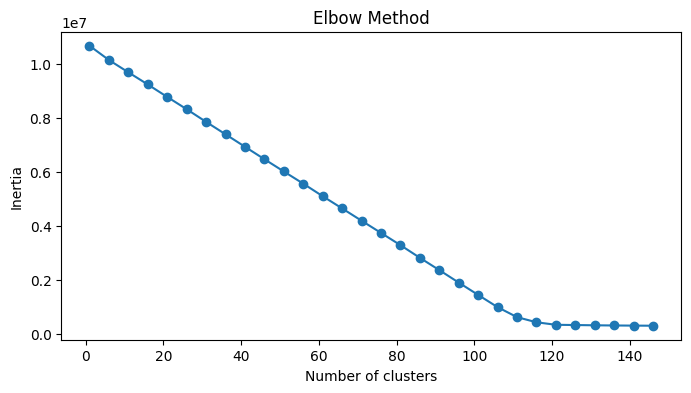

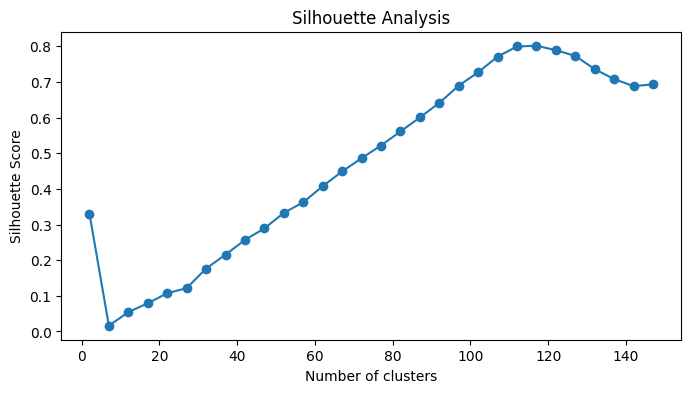

In [5]:
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans  # GPU-accelerated KMeans
from cuml.metrics.cluster import silhouette_score as cuSilhouetteScore  # GPU-accelerated silhouette score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

def elbow_method(data, max_clusters=150, step=5, start=1):
    inertia = []
    cluster_range = range(start, max_clusters + 1, step)
    for n_clusters in cluster_range:
        kmeans = cuKMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(cluster_range, inertia, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

def silhouette_analysis(data, max_clusters=150, step=5, start=1):
    silhouette_scores = []
    cluster_range = range(start+1, max_clusters + 1, step)
    for n_clusters in cluster_range:
        kmeans = cuKMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = cuSilhouetteScore(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    plt.figure(figsize=(8, 4))
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.title('Silhouette Analysis')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

# Load your music dataset
music_data_path = '/dataset/maharshipandya-spotify-tracks-dataset/dataset.csv'
df_music = pd.read_csv(music_data_path)
df_music.drop_duplicates(subset=['track_id'], inplace=True)
df_music_used = df_music[['popularity', 'energy', 'tempo', 'valence', 'danceability', 'loudness']]
df_music_used.info()

# One-hot encode 'track_genre'
encoder = OneHotEncoder()
encoded_genres = encoder.fit_transform(df_music[['track_genre']])

# Convert to DataFrame
encoded_genres_df = pd.DataFrame(encoded_genres.toarray(), columns=encoder.get_feature_names_out(['track_genre']))

# Combine with other song features
song_features = pd.concat([df_music_used.reset_index(drop=True), encoded_genres_df.reset_index(drop=True)], axis=1)
song_features.info()

# Scale the data
scaler = StandardScaler()
scaled_song_features = scaler.fit_transform(song_features)


elbow_method(scaled_song_features, 150, 5, 1)
silhouette_analysis(scaled_song_features, 150, 5, 1)


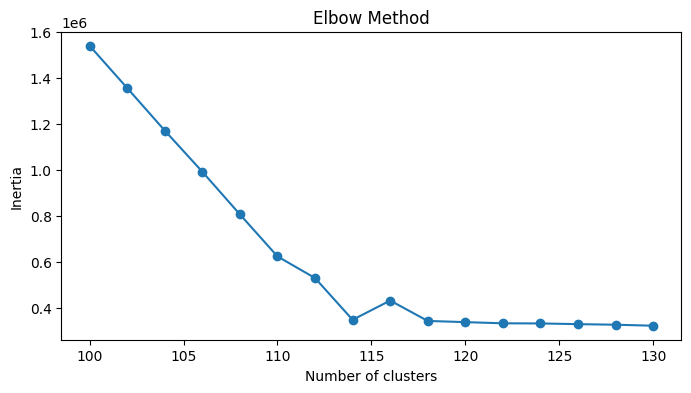

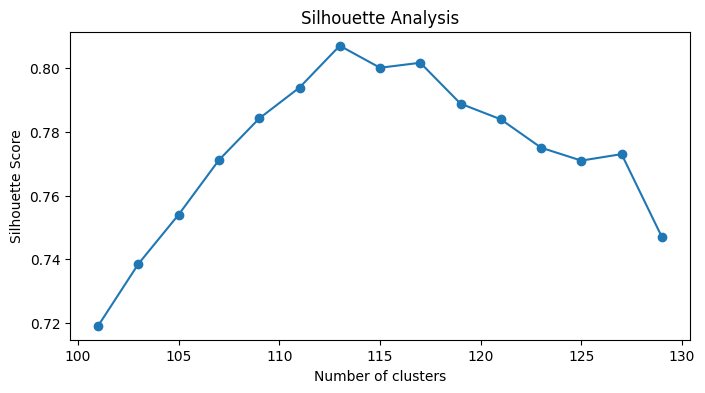

In [6]:
# More precision
elbow_method(scaled_song_features, 130, 2, 100)
silhouette_analysis(scaled_song_features, 130, 2, 100)